<a href="https://colab.research.google.com/github/byein/CAPTCHA_reader/blob/main/captcha_reader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yebkim","key":"9087c0a2cfce87113d835781c46f5915"}'}

In [4]:
!ls -al
!mkdir -p ~/.kaggle
!ls -al ~/

total 20
drwxr-xr-x 1 root root 4096 Dec 17 10:58 .
drwxr-xr-x 1 root root 4096 Dec 17 10:52 ..
drwxr-xr-x 4 root root 4096 Dec  3 14:33 .config
-rw-r--r-- 1 root root   62 Dec 17 10:58 kaggle.json
drwxr-xr-x 1 root root 4096 Dec  3 14:33 sample_data
total 64
drwx------ 1 root root 4096 Dec 17 10:58 .
drwxr-xr-x 1 root root 4096 Dec 17 10:52 ..
-r-xr-xr-x 1 root root 1169 Jan  1  2000 .bashrc
drwxr-xr-x 1 root root 4096 Dec 14 14:13 .cache
drwxr-xr-x 1 root root 4096 Dec 14 14:11 .config
drwxr-xr-x 3 root root 4096 Dec  3 14:33 .gsutil
drwxr-xr-x 5 root root 4096 Dec 14 14:11 .ipython
drwx------ 2 root root 4096 Dec 14 14:11 .jupyter
drwxr-xr-x 2 root root 4096 Dec 17 10:58 .kaggle
drwxr-xr-x 2 root root 4096 Dec 17 10:52 .keras
drwx------ 1 root root 4096 Dec 14 14:11 .local
drwxr-xr-x 4 root root 4096 Dec 14 14:11 .npm
-rw-r--r-- 1 root root  148 Aug 17  2015 .profile
-r-xr-xr-x 1 root root  254 Jan  1  2000 .tmux.conf


In [5]:
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!ls -al ~/.kaggle/

total 16
drwxr-xr-x 2 root root 4096 Dec 17 10:59 .
drwx------ 1 root root 4096 Dec 17 10:58 ..
-rw------- 1 root root   62 Dec 17 10:59 kaggle.json


In [6]:
!kaggle datasets download -d fournierp/captcha-version-2-images

 63% 11.0M/17.4M [00:00<00:00, 43.9MB/s]
100% 17.4M/17.4M [00:00<00:00, 58.1MB/s]


In [7]:
!unzip captcha-version-2-images.zip

Archive:  captcha-version-2-images.zip
  inflating: samples/226md.png       
  inflating: samples/22d5n.png       
  inflating: samples/2356g.png       
  inflating: samples/23mdg.png       
  inflating: samples/23n88.png       
  inflating: samples/243mm.png       
  inflating: samples/244e2.png       
  inflating: samples/245y5.png       
  inflating: samples/24f6w.png       
  inflating: samples/24pew.png       
  inflating: samples/25257.png       
  inflating: samples/253dc.png       
  inflating: samples/25egp.png       
  inflating: samples/25m6p.png       
  inflating: samples/25p2m.png       
  inflating: samples/25w53.png       
  inflating: samples/264m5.png       
  inflating: samples/268g2.png       
  inflating: samples/28348.png       
  inflating: samples/28x47.png       
  inflating: samples/2b827.png       
  inflating: samples/2bg48.png       
  inflating: samples/2cegf.png       
  inflating: samples/2cg58.png       
  inflating: samples/2cgyx.png       
  inflating

#Import Required libraries

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import numpy as np
import pandas as pd
from tensorflow import keras as k
from keras.utils import np_utils
import cv2
from PIL import Image
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Flatten, Conv2D, Dropout, Dense

#Loading Dataset and Preprocessing

In [19]:
X=[]
y=[]

# Since there are subfolders inside the input directory, we've used nested loops
for dirname, _, filenames in os.walk('samples'):
    for filename in filenames:
        path=os.path.join(dirname, filename) 
        
# Preprocessing the image:
# - read image
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

# - Adaptive Threshold: For every pixel, the same threshold value is applied. If the pixel value
# is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value
# It removes the greyish tinge off the image.
        image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
  
# - Closing: It is useful in closing small holes inside the foreground objects, 
# or small black points on the object
        kernel = np.ones((5,5),np.uint8)
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        
# - Dilation: So it increases the white region in the image or 
# size of foreground object increases
        kernel = np.ones((2,2),np.uint8)
        image = cv2.dilate(image, kernel, iterations = 1)
 
# - Blur: As in one-dimensional signals, images also can be filtered with various low-pass filters (LPF), high-pass filters (HPF), etc.
# LPF helps in removing noise, blurring images, etc. HPF filters help in finding edges in images.
        image = cv2.GaussianBlur(image, (5,5), 0)
 

# Splitting up the image into sections of each character
        x=[image[10:50,30:50],image[10:50,50:70],
                 image[10:50,70:90],image[10:50,90:110],image[10:50,110:130]]

# Labelling segments with the image name
        for i in range(5):
            X.append(img_to_array(Image.fromarray(x[i])))
            y.append(path[len(path)-9:len(path)-4][i])
X=np.array(X)
y=np.array(y)


#Scaling X values; Label Encoding and One Hot Encoding the labels

In [20]:
X=X.astype('float32')
X/=255

y_le = LabelEncoder().fit_transform(y)
y_ohe = OneHotEncoder(sparse = False).fit_transform(y_le.reshape(len(y_le),1))

X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size = 0.2, random_state = 42)

row, col = X.shape[1],X.shape[2]
categories = y_ohe.shape[1]

info = {y_le[i] : y[i] for i in range(len(y))}


#Creating the CNN architecture

In [21]:
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same', input_shape=(row,col,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(1500))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(categories))
model.add(Activation("softmax"))

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam' ,
              metrics = ['accuracy'])

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 20, 16)        160       
                                                                 
 activation (Activation)     (None, 40, 20, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 10, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 10, 16)        2320      
                                                                 
 activation_1 (Activation)   (None, 20, 10, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 5, 16)        0         
 2D)                                                    

#Fitting and training data into model¶


In [22]:
batch_size = 150
epochs = 200

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          shuffle=True)

Epoch 1/200
58/58 [==============================] - 8s 108ms/step - loss: 2.6547 - accuracy: 0.1743 - val_loss: 1.8379 - val_accuracy: 0.4659
Epoch 2/200
58/58 [==============================] - 6s 100ms/step - loss: 1.6373 - accuracy: 0.5125 - val_loss: 1.1160 - val_accuracy: 0.7019
Epoch 3/200
58/58 [==============================] - 6s 105ms/step - loss: 1.1893 - accuracy: 0.6500 - val_loss: 0.8519 - val_accuracy: 0.7664
Epoch 4/200
58/58 [==============================] - 7s 129ms/step - loss: 0.9562 - accuracy: 0.7259 - val_loss: 0.6618 - val_accuracy: 0.8037
Epoch 5/200
58/58 [==============================] - 7s 117ms/step - loss: 0.8350 - accuracy: 0.7502 - val_loss: 0.6021 - val_accuracy: 0.8215
Epoch 6/200
58/58 [==============================] - 6s 104ms/step - loss: 0.7563 - accuracy: 0.7743 - val_loss: 0.5351 - val_accuracy: 0.8528
Epoch 7/200
58/58 [==============================] - 6s 112ms/step - loss: 0.6914 - accuracy: 0.7951 - val_loss: 0.5152 - val_accuracy: 0.8556

#Evaluating performance of the model¶


In [23]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

67/67 [==============================] - 1s 12ms/step - loss: 0.1589 - accuracy: 0.9724
Test loss: 0.15891605615615845
Test accuracy: 0.9724299311637878


#Prediction Function:
The purpose of this function is to process raw images into model-comprehensible data for better prediction. As we've done in data preprocessing

In [24]:
def pred (img_path) :
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    
    image = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
    kernel = np.ones((5,5),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernel, iterations = 1)
    image = cv2.GaussianBlur(image, (5,5), 0)
    
    
    x = [image[10:50, 30:50], image[10:50, 50:70], image[10:50, 70:90],
                  image[10:50, 90:110], image[10:50, 110:130]]
    
    X_pred = []
    for i in range(5) :
        X_pred.append(img_to_array(Image.fromarray(x[i])))
    
    X_pred = np.array(X_pred)
    X_pred/= 255.0
    
    y_pred = model.predict(X_pred)
    y_pred = np.argmax(y_pred, axis = 1)
    
    print('Prediction: ', end='')
    for res in y_pred :
        print(info[res], end='')
        
    print('\nActual:    ', img_path[len(img_path)-9:len(img_path)-4])

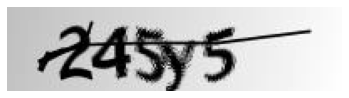

Prediction: 245y5
Actual:     245y5


In [26]:
pred('samples/samples/245y5.png')


In [27]:
model.save('captcha_recognizer.h5')
